In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import numpy as np

tf.config.run_functions_eagerly(True)

In [ ]:
#Load data
batch_size = 16 
SIZE = 128 # 128 * 128

imgs_input_path = '/kaggle/input/dataset-4-frame-prediction1/ourDataset/input'
imgs_target_path = '/kaggle/input/dataset-4-frame-prediction1/ourDataset/target'

def load_images(data_path):
    array_data = []
    for image_file in os.listdir( data_path ):
        image = Image.open( os.path.join( data_path , image_file ) ).resize( ( SIZE , SIZE ) )
        # Normalize the image array
        #scaling the pixel values to the range [0, 1]
        img_input_array = (np.asarray( image ) ) / 255
        # Append the image
        array_data.append( img_input_array )
    
    return array_data


imgs_input = load_images(imgs_input_path)
imgs_target = load_images(imgs_target_path)

# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(imgs_input) , np.array(imgs_target) , test_size=0.1 )
# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )

In [ ]:
#VAE model
def build_vae(input_dim, latent_dim):
    # Encoder
    inputs = Input(shape=(input_dim,))
    h = Dense(256, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    # Use Lambda layer to create a layer from the sampling function
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder
    decoder_h = Dense(256, activation='relu')
    decoder_mean = Dense(input_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    #custom loss function
    def vae_loss(x, x_decoded_mean):
        xent_loss = input_dim * binary_crossentropy(x, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss

    # build + compile
    vae = Model(inputs, x_decoded_mean)
    vae.add_loss(vae_loss(inputs, x_decoded_mean))
    vae.compile(optimizer='adam')

    encoder = Model(inputs, z)
    decoder_input = Input(shape=(latent_dim,))
    
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    decoder = Model(decoder_input, _x_decoded_mean)

    return vae, encoder, decoder

# Set random seed for reproducibility
"""np.random.seed(42)
tf.random.set_seed(42)"""

latent_dim = 2
#  A VAE is a type of generative model that learns 
# a probabilistic mapping between input data and a latent space, allowing for the generation of new data points.
# Build the VAE model
vae, encoder, decoder = build_vae(SIZE*SIZE*3, latent_dim)

In [ ]:
vae.summary()

In [ ]:
# Compile VAE
vae.compile(optimizer='adam', loss=None)

# Train autoencoder
vae.fit(train_x, train_y, epochs = 1000, batch_size = 16, validation_split = 0.1)

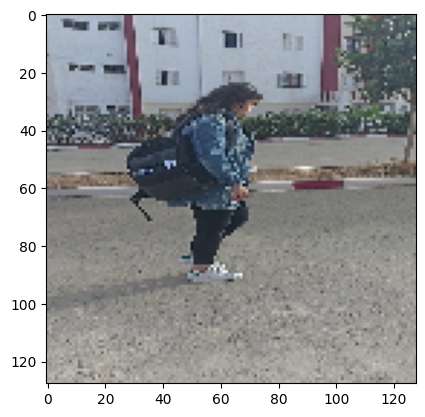

In [105]:
import cv2
img = cv2.imread('/kaggle/input/dataset-4-frame-prediction1/ourDataset/input/trame102.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #Changing BGR to RGB to show images in true colors
img=cv2.resize(img,(SIZE, SIZE))
plt.imshow(img.reshape(SIZE,SIZE,3))

In [ ]:
# Generate new samples by sampling from the latent space
num_generated_samples = 100
random_latent_samples = np.random.normal(size=(num_generated_samples, latent_dim))
generated_images = decoder.predict(random_latent_samples)
frames = [generated_images[i].reshape((SIZE, SIZE, 3)).astype(np.uint8) for i in range(num_generated_samples)]

# Plot the generated images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(generated_images[i].reshape((SIZE, SIZE, 3)))
    plt.title(f'Generated {i + 1}')
    #plt.savefig(f'generation{i + 1}.png')
    plt.axis('off')

#plt.savefig('generation.png')
plt.show()

In [ ]:
import imageio

imageio.mimsave('results.gif', frames, duration = 0.3)

In [ ]:
vae.save("vae.keras")
decoder.save("decoder.keras")

In [103]:
from tensorflow import keras
decoder_path = '/kaggle/working/decoder.keras'
loaded_decoder = keras.models.load_model(decoder_path)

4/4 [==============================] - 0s 17ms/step


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


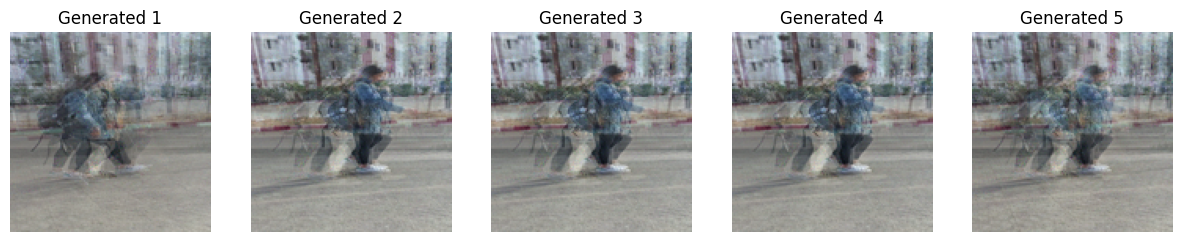

In [104]:
# Generate new samples by sampling from the latent space
num_generated_samples = 100
random_latent_samples = np.random.normal(size=(num_generated_samples, latent_dim))
generated_images = loaded_decoder.predict(random_latent_samples)
frames = [generated_images[i].reshape((SIZE, SIZE, 3)).astype(np.uint8) for i in range(num_generated_samples)]

# Plot the generated images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(generated_images[i].reshape((SIZE, SIZE, 3)))
    plt.title(f'Generated {i + 1}')
    #plt.savefig(f'generation{i + 1}.png')
    plt.axis('off')

#plt.savefig('generation.png')
plt.show()

### **OPTICAL FLOW**

In [ ]:
import numpy as np
import cv2

video1_path = 'linda.mp4'
cap = cv2.VideoCapture(video1_path)

"""SHITOMASI CORNER DETECTION"""
feature_params = dict(maxCorners=100,
                      qualityLevel=0.3,
                      minDistance=7,
                      blockSize=7)

# lucas kanade optical flow PARAMS
lucas_kanade_params = dict(winSize=(15, 15),
                           maxLevel=2,
                           criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
# Used to create our trails for object movement in the images
color = np.random.randint(0, 255, (100, 3))

# Take first frame and find corners in it
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Find inital corner locations
prev_corners = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(prev_frame)

frame_counter = 0
# Initialize motion vectors
motion_vectors = []

while 1:
    ret, frame = cap.read()
    frame_counter += 1
    if frame_counter == int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-1:
        frame_counter = 0
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        motion_vectors = np.array(motion_vectors)
        np.save('motion_vectors.npy', motion_vectors)
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    new_corners, status, errors = cv2.calcOpticalFlowPyrLK(prev_gray,
                                                           frame_gray,
                                                           prev_corners,
                                                           None,
                                                           **lucas_kanade_params)

    # Select and store good points
    good_new = new_corners[status == 1]
    good_old = prev_corners[status == 1]

    # Draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)

    img = cv2.add(frame, mask)

    # Calculate the motion vector
    motion_vector = np.mean(good_new - good_old, axis=0)
    motion_vectors.append(motion_vector)

    # Show Optical Flow
    cv2.imshow('Optical Flow - Lucas-Kanade', img)
    if cv2.waitKey(1) == 13:  # 13 is the Enter Key
        break

    # Now update the previous frame and previous points
    prev_gray = frame_gray.copy()
    prev_corners = good_new.reshape(-1, 1, 2)


cv2.destroyAllWindows()
cap.release()

### cVAE

In [ ]:
from tensorflow.keras.layers import concatenate

# Assuming motion vectors have shape (batch_size, motion_dim)
motion_dim = ...  # Set the dimensionality of your motion vectors

# Modify your VAE architecture
def build_conditioned_vae(input_dim, latent_dim, motion_dim):
    inputs_image = Input(shape=(input_dim,))
    inputs_motion = Input(shape=(motion_dim,))

    # Concatenate image and motion vector
    combined_inputs = concatenate([inputs_image, inputs_motion])

    # Modify the rest of your encoder and decoder architecture to use combined_inputs

    # Build the VAE model
    vae, encoder, decoder = build_vae(input_dim + motion_dim, latent_dim)

    # Adjust the loss function to include motion information
    def conditioned_vae_loss(x, x_decoded_mean):
        # Add a term penalizing the difference between predicted and ground truth motion vectors
        motion_loss = K.mean(K.square(inputs_motion - predicted_motion_vector), axis=-1)
        
        # Your existing reconstruction loss (binary cross-entropy or other)
        xent_loss = input_dim * binary_crossentropy(x, x_decoded_mean)
        
        return xent_loss + motion_loss

    vae.add_loss(conditioned_vae_loss(combined_inputs, x_decoded_mean))

    return vae, encoder, decoder

# Assuming you have a dataset with motion vectors
# Modify your data loading to include motion vectors

# Load and preprocess the data
imgs_input = load_images(imgs_input_path)
imgs_target = load_images(imgs_target_path)
motion_vectors = load_motion_vectors(motion_vectors_path)  # Load your motion vectors

# Concatenate images and motion vectors
combined_data = np.concatenate([imgs_input, motion_vectors], axis=1)

# Train the conditioned VAE
conditioned_vae, conditioned_encoder, conditioned_decoder = build_conditioned_vae(input_dim + motion_dim, latent_dim, motion_dim)
conditioned_vae.fit(combined_data, epochs=epochs, batch_size=batch_size)
